# EEEL 4220 Project

In [2]:
import cvxpy as cp
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
#import cartopy.crs as ccrs
#import cartopy.feature as cf
import matplotlib.pyplot as plt
#from geopy.geocoders import Nominatim
import time

In [64]:
# Country to number mapping
countries = {
    "Austria": 0, "Belgium": 1, "Bulgaria": 2, "Croatia": 3, "Czechia": 4, 
    "Denmark": 5, "Estonia": 6, "Finland": 7, "France": 8, "Germany": 9, 
    "Greece": 10, "Hungary": 11, "Ireland": 12, "Italy": 13, "Latvia": 14, 
    "Lithuania": 15, "Luxembourg": 16, "Netherlands": 17, "Poland": 18, "Portugal": 19, 
    "Romania": 20, "Slovakia": 21, "Slovenia": 22, "Spain": 23, "Sweden": 24, 
    "Norway": 25, "Switzerland": 26, "United Kingdom": 27
}

countries_reverse = {value: key for key, value in countries.items()}

# Line mapping to countries
line_mapping = [
    (countries["Austria"], countries["Switzerland"], 1890),
    (countries["Austria"], countries["Germany"], 3670),
    (countries["Austria"], countries["Hungary"], 1830),
    (countries["Austria"], countries["Italy"], 260),
    (countries["Austria"], countries["Slovenia"], 1550),
    (countries["Belgium"], countries["Luxembourg"], 290),
    (countries["Belgium"], countries["United Kingdom"], 1040),
    (countries["Bulgaria"], countries["Greece"], 560),
    (countries["Czechia"], countries["Austria"], 2610),
    (countries["Czechia"], countries["Slovakia"], 2330),
    (countries["Germany"], countries["Belgium"], 0),
    (countries["Germany"], countries["Switzerland"], 5910),
    (countries["Germany"], countries["Czechia"], 2860),
    (countries["Germany"], countries["Luxembourg"], 790),
    (countries["Germany"], countries["Netherlands"], 5070),
    (countries["Germany"], countries["Norway"], 0),
    (countries["Germany"], countries["Poland"], 2030),
    (countries["Denmark"], countries["Germany"], 2240),
    (countries["Denmark"], countries["Norway"], 2350),
    (countries["Denmark"], countries["Sweden"], 2070),
    (countries["Estonia"], countries["Latvia"], 830),
    (countries["Finland"], countries["Estonia"], 1020),
    (countries["Finland"], countries["Sweden"], 2770),
    (countries["France"], countries["Belgium"], 3690),
    (countries["France"], countries["Switzerland"], 4190),
    (countries["France"], countries["Germany"], 5220),
    (countries["France"], countries["Spain"], 3640),
    (countries["France"], countries["United Kingdom"], 2040),
    (countries["Croatia"], countries["Slovenia"], 1500),
    (countries["Hungary"], countries["Croatia"], 1650),
    (countries["Hungary"], countries["Slovenia"], 0),
    (countries["Hungary"], countries["Slovakia"], 2010),
    (countries["Ireland"], countries["United Kingdom"], 530),
    (countries["Italy"], countries["Switzerland"], 4810),
    (countries["Italy"], countries["France"], 3560),
    (countries["Italy"], countries["Greece"], 510),
#   (countries["Italy"], countries["Malta"], 220),
    (countries["Italy"], countries["Slovenia"], 1680),
    (countries["Lithuania"], countries["Poland"], 490),
    (countries["Latvia"], countries["Lithuania"], 1190),
    (countries["Netherlands"], countries["Belgium"], 3610),
    (countries["Netherlands"], countries["Denmark"], 700),
    (countries["Netherlands"], countries["Norway"], 730),
    (countries["Netherlands"], countries["United Kingdom"], 1090),
    (countries["Norway"], countries["Finland"], 140),
    (countries["Czechia"], countries["Poland"], 1670),
    (countries["Portugal"], countries["Spain"], 3980),
    (countries["Romania"], countries["Bulgaria"], 1300),
    (countries["Romania"], countries["Hungary"], 870),
    (countries["Sweden"], countries["Germany"], 610),
    (countries["Sweden"], countries["Lithuania"], 730),
    (countries["Sweden"], countries["Norway"], 5460),
    (countries["Sweden"], countries["Poland"], 600),
    (countries["United Kingdom"], countries["Norway"], 0),
]

In [4]:
with open('countryData.pkl', 'rb') as f:
    data = pickle.load(f)
with open('aggregatedGenCapacity.pkl', 'rb') as f:
    gendata = pickle.load(f)
with open('capacityFactor_solar.pkl', 'rb') as f:
    solarCF = pickle.load(f)
with open('capacityFactor_wind.pkl', 'rb') as f:
    windCF = pickle.load(f)

In [262]:
genTypeEmissions = {
    'Biomass'                         : 66,
    'Coal'                            : 990,
    'Gas'                             : 420,
    'Hydro'                           : 19, 
    'Nuclear'                         : 25, 
    'Solar'                           : 41, 
    'Wind'                            : 11
}

gen_types = ["Coal", "Gas", "Biomass", "Wind", "Solar"]

LCOE_original = {
  'Solar' : 90,
  'Wind' : 60,
  'Biomass': 151,
  'Gas' : 95,
  'Coal': 90, #Actual value 90
  'Nuclear' : 70,
  'Hydro': 69
}

LCOE =  {
  'Solar' : 90*0.95,
  'Wind' : 60*0.95,
  'Biomass': 151,
  'Gas' : 95,
  'Coal': 90,
  'Nuclear' : 70,
  'Hydro': 69
}

In [250]:
#for country in countries.keys():
    #print(f' Solar Capacity factor of {country}:', solarCF[country].mean())
    #print(f' Wind Capacity factor of {country}:', windCF[country].mean())
    #print('')

solarCF_bis = solarCF.copy()

solarCF_bis['Estiona'] = solarCF_bis['Lithuania']
solarCF_bis['Latvia']  = solarCF_bis['Lithuania']
solarCF_bis['Ireland'] = solarCF_bis['United Kingdom']
solarCF_bis['Poland']  = solarCF_bis['Germany']
solarCF_bis['Hungary'] = solarCF_bis['Slovakia']
solarCF_bis['Netherlands'] = solarCF_bis['Belgium']

In [251]:
def optimize_power_system(data, capacities, windCF, solarCF):
    # Define constants
    num_countries = len(countries)
    num_hours = len(data['France']['Hydro'].values.tolist())  # Assuming 96 hours in the dataset
    print('Data has ', num_hours, ' hours.')
    num_lines = len(line_mapping)
    reactance_value = 0.2
    X = np.full(num_lines, reactance_value)
    f = cp.Variable((num_hours, num_lines))  # Line flow
    theta = cp.Variable((num_hours, num_countries))
    # Initialize arrays for demands, prices, and capacity factors
    demands = np.zeros((num_hours, num_countries))
    prices = np.zeros((num_hours, num_countries))
    windCFs = np.zeros((num_hours, num_countries))
    solarCFs = np.zeros((num_hours, num_countries))

    # Populate the arrays with data
    for i, country in enumerate(countries):
        for hour in range(num_hours):
            demands[hour, i] = data[country]['Load'].iloc[hour]
            prices[hour, i] = data[country]['Day-ahead Prices'].iloc[hour]
            windCFs[hour, i] = windCF[country].iloc[hour]
            solarCFs[hour, i] = solarCF[country].iloc[hour]

    # Define variables for generation types for each country
    fossil_types = ['Gas', 'Biomass', 'Coal']
    fossil_fuel_gen = {gen_type: cp.Variable((num_hours, num_countries), nonneg=True) for gen_type in fossil_types}
    installed_wind = cp.Variable(num_countries, nonneg=True)
    installed_solar = cp.Variable(num_countries, nonneg=True)

    # Define constraints and solve the problem
    con_set = []

    # Nodal power balance constraints
    for c in range(num_countries):
        # Get lines connected to this country
        incoming_lines = [j for j, (from_country, to_country, _) in enumerate(line_mapping) if to_country == c]
        outgoing_lines = [j for j, (from_country, to_country, _) in enumerate(line_mapping) if from_country == c]
        
        # Sum the inflows and outflows for lines connected to this country
        for h in range(num_hours):
            line_inflows  = sum(f[h, j] for j in incoming_lines)  # Sum of incoming line flows
            line_outflows = sum(f[h, j] for j in outgoing_lines)  # Sum of outgoing line flows
            gen_hour_h_country_c = fossil_fuel_gen['Gas'][h, c] + fossil_fuel_gen['Coal'][h, c] + fossil_fuel_gen['Biomass'][h, c]
            gen_hour_h_country_c += data[countries_reverse[c]]['Nuclear'].iloc[h] + data[countries_reverse[c]]['Hydro'].iloc[h]
            gen_hour_h_country_c += installed_wind[c]*windCFs[h, c] + installed_solar[c]*solarCFs[h, c]
            # Create nodal power balance equation with CF adjusted generation
            con_set.append(gen_hour_h_country_c + line_inflows == demands[h, c] + line_outflows)
            #con_set.append(gen_hour_h_country_c == demands[h, c])

    print('All Load Constraints are up to i = ', len(con_set))
    # Power flow constraints
    for h in range(num_hours):
        con_set.append(theta[h, 0] == 0)
        for i, (from_country, to_country, capacity) in enumerate(line_mapping):
            # Power flow equation constraint - Not necessary because reactance is taken as 0.2 for all lines
            #con_set.append(f[h, i] == (theta[h, from_country] - theta[h, to_country]) / X[i])
            # Transmission capacity constraint for each line
            con_set.append(cp.abs(f[h, i]) <= capacity)

    for country, cnum in countries.items():
        for h in range(num_hours):
            con_set.append(fossil_fuel_gen['Biomass'][h, cnum] <= capacities[country]['Biomass'])
            con_set.append(fossil_fuel_gen['Coal'][h, cnum]    <= capacities[country]['Coal'])
            con_set.append(fossil_fuel_gen['Gas'][h, cnum]     <= capacities[country]['Gas'])
    
    # Total generation costs calculation
    coal_gen, gas_gen, biomass_gen = 0, 0, 0

    for h in range(num_hours):
        for c in range(num_countries):
            coal_gen    += fossil_fuel_gen['Coal'][h, c]
            gas_gen     += fossil_fuel_gen['Gas'][h, c]
            biomass_gen += fossil_fuel_gen['Biomass'][h, c]

    coal_emissions  = coal_gen * genTypeEmissions['Coal']
    coal_costs      = coal_gen * LCOE['Coal']

    #gas_gen         = cp.sum(fossil_fuel_gen['Gas'])
    gas_emissions   = gas_gen * genTypeEmissions['Gas']
    gas_costs       = gas_gen * LCOE['Gas']

    #biomass_gen        = cp.sum(fossil_fuel_gen['Biomass'])
    biomass_emissions  = biomass_gen * genTypeEmissions['Biomass']
    biomass_costs      = biomass_gen * LCOE['Biomass']

    wind_gen, solar_gen = 0, 0
    for c in range(num_countries):
        wind_gen  += installed_wind[c]  * np.sum(windCFs[:,c]) 
        solar_gen += installed_solar[c] * np.sum(solarCFs[:,c]) 

    wind_emissions  = wind_gen * genTypeEmissions['Wind']
    wind_costs      = wind_gen * LCOE['Wind']

    #solar_gen        = cp.multiply(installed_solar, np.average(solarCFs, axis=0)) 
    solar_emissions  = solar_gen * genTypeEmissions['Solar']
    solar_costs      = solar_gen * LCOE['Solar']

    nuclear_gen        = sum(data[country]['Nuclear'].sum() for country in data.keys())
    nuclear_emissions  = nuclear_gen * genTypeEmissions['Nuclear']
    nuclear_costs      = nuclear_gen * LCOE['Nuclear']

    hydro_gen        = sum(data[country]['Hydro'].sum() for country in data.keys())
    hydro_emissions  = hydro_gen * genTypeEmissions['Hydro']
    hydro_costs      = hydro_gen * LCOE['Hydro']

    total_emissions = coal_emissions + gas_emissions + biomass_emissions + wind_emissions + solar_emissions + nuclear_emissions + hydro_emissions
    total_gen       = coal_gen + gas_gen + biomass_gen + wind_gen + solar_gen + nuclear_gen + hydro_gen
    total_costs     = coal_costs + gas_costs + biomass_costs + wind_costs + solar_costs + nuclear_costs + hydro_costs
    
    con_set.append(total_emissions <= 150*total_gen)
    
    # LCOE = LCOE' + IC, LCOE' = 0.95LCOE
    # --> IC = 5.27% LCOE'
    IC_wind = LCOE['Wind']*0.0527
    IC_solar = LCOE['Solar'] * 0.0527
    obj = cp.Minimize(total_costs + IC_solar*sum(installed_solar[c] for c in range(num_countries)) + IC_wind*sum(installed_wind[c] for c in range(num_countries)))
    
    # Create and solve the problem
    prob = cp.Problem(obj, con_set)
    prob.solve(verbose=True)
    #prob.solve(solver="GUROBI", verbose=True)

    # Store results for this hour
    data_output = {}
    transmission_output = f.value
    dualPrices = {}

    for country, cnum in countries.items():
        load        = data[country]['Load']
        bus_prices = []
        for h in range(num_hours):
            bus_prices.append(con_set[h+cnum*96].dual_value)
            
        coal_gen    = fossil_fuel_gen['Coal'][:, cnum].value
        gas_gen     = fossil_fuel_gen['Gas'][:, cnum].value
        biomass_gen = fossil_fuel_gen['Biomass'][:, cnum].value
        solar_cap   = installed_solar[cnum].value
        wind_cap    = installed_wind[cnum].value
        solar_gen   = solar_cap*solarCF[country]
        wind_gen    = wind_cap*windCF[country]
        
        hourly_emissions = coal_gen*genTypeEmissions['Coal'] + gas_gen*genTypeEmissions['Gas'] + biomass_gen*genTypeEmissions['Biomass']
        hourly_emissions += solar_gen*genTypeEmissions['Solar'] + wind_gen*genTypeEmissions['Wind']
        hourly_emissions += data[country]['Nuclear']*genTypeEmissions['Nuclear'] + data[country]['Hydro']*genTypeEmissions['Hydro']
        hourly_emissions = hourly_emissions / (coal_gen + gas_gen + biomass_gen + solar_gen + wind_gen + data[country]['Nuclear'] + data[country]['Hydro'])
        
        df_data_output = pd.DataFrame(index = data[country].index)
        df_data_output.insert(0, 'Bus Prices', bus_prices)
        df_data_output.insert(1, 'Demand', load)
        df_data_output.insert(2, 'Gen. Emissions', hourly_emissions)
        df_data_output.insert(3, 'Solar Capacity', solar_cap)
        df_data_output.insert(4, 'Wind Capacity', wind_cap)
        df_data_output.insert(5, 'Solar Generation', solar_gen)
        df_data_output.insert(6, 'Wind Generation', wind_gen)
        df_data_output.insert(7, 'Nuclear Generation', data[country]['Nuclear'])
        df_data_output.insert(8, 'Hydro Generation', data[country]['Hydro'])
        df_data_output.insert(9, 'Gas Generation', gas_gen)
        df_data_output.insert(10, 'Coal Generation', coal_gen)
        df_data_output.insert(11, 'Biomass Generation', biomass_gen)
        data_output[country] = df_data_output

    cp_emissions = total_emissions.value / total_gen.value
    #total_generation = sum(g.value for g in generators.values())

    #bus_prices = [con_set[1+96*cnum:6].dual_value for i in range(0, len(countries))]
    #hourly_results.append({
    #    'hour': hour,
    #    'total_cost': prob.value,
    #    'generation_amounts': [g.value for g in generators.values()],
    #    'bus_prices': bus_prices,
    #    'transmission': f.value,
    #    'total_generation': total_generation
    #})

    return data_output, transmission_output, [total_emissions.value, total_gen.value, cp_emissions]

In [252]:
# Initialize a list to store bus prices for each hour
hourly_bus_prices = []
hourly_generation = []
hourly_transmission = []

smallData = {}
smallWindCF, smallSolarCF = {}, {}
for country in countries.keys():
    smallData[country] = data[country].iloc[0:24]
    smallWindCF[country]  = windCF[country].iloc[0:24]
    smallSolarCF[country] = solarCF[country].iloc[0:24]

data_output, transmission_output, cp_emissions = optimize_power_system(data, gendata, windCF, solarCF_bis)

#data_output, transmission_output = optimize_power_system(smallData, gendata, smallWindCF, smallSolarCF)

Data has  96  hours.
All Load Constraints are up to i =  2688


C:\Users\matth\anaconda3\envs\energyOpt\Lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
C:\Users\matth\anaconda3\envs\energyOpt\Lib\site-packages\cvxpy\problems\problem.py:164: UserWarning: Constraint #15936 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Dec 15 08:14:54 PM: Your problem has 15896 variables, 15937 constraints, and 0 parameters.
(CVXPY) Dec 15 08:14:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 15 08:14:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 15 08:14:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 15 08:14:56 PM: Compiling problem (target solver=ECOS).
(CVXPY) Dec 15 08:14:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuf

C:\Users\matth\anaconda3\envs\energyOpt\Lib\site-packages\cvxpy\problems\problem.py:164: UserWarning: Constraint #26112 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


(CVXPY) Dec 15 08:15:00 PM: Applying reduction ConeMatrixStuffing


C:\Users\matth\anaconda3\envs\energyOpt\Lib\site-packages\cvxpy\problems\problem.py:164: UserWarning: Constraint #26117 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


(CVXPY) Dec 15 08:15:13 PM: Applying reduction ECOS
(CVXPY) Dec 15 08:15:18 PM: Finished problem compilation (took 2.294e+01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Dec 15 08:15:18 PM: Invoking solver ECOS  to obtain a solution.
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Dec 15 08:15:19 PM: Problem status: optimal
(CVXPY) Dec 15 08:15:19 PM: Optimal value: 2.405e+09
(CVXPY) Dec 15 08:15:19 PM: Compilation took 2.294e+01 seconds
(CVXPY) Dec 15 08:15:19 PM: Solver (including time spent in interface) took 2.404e-01 seconds


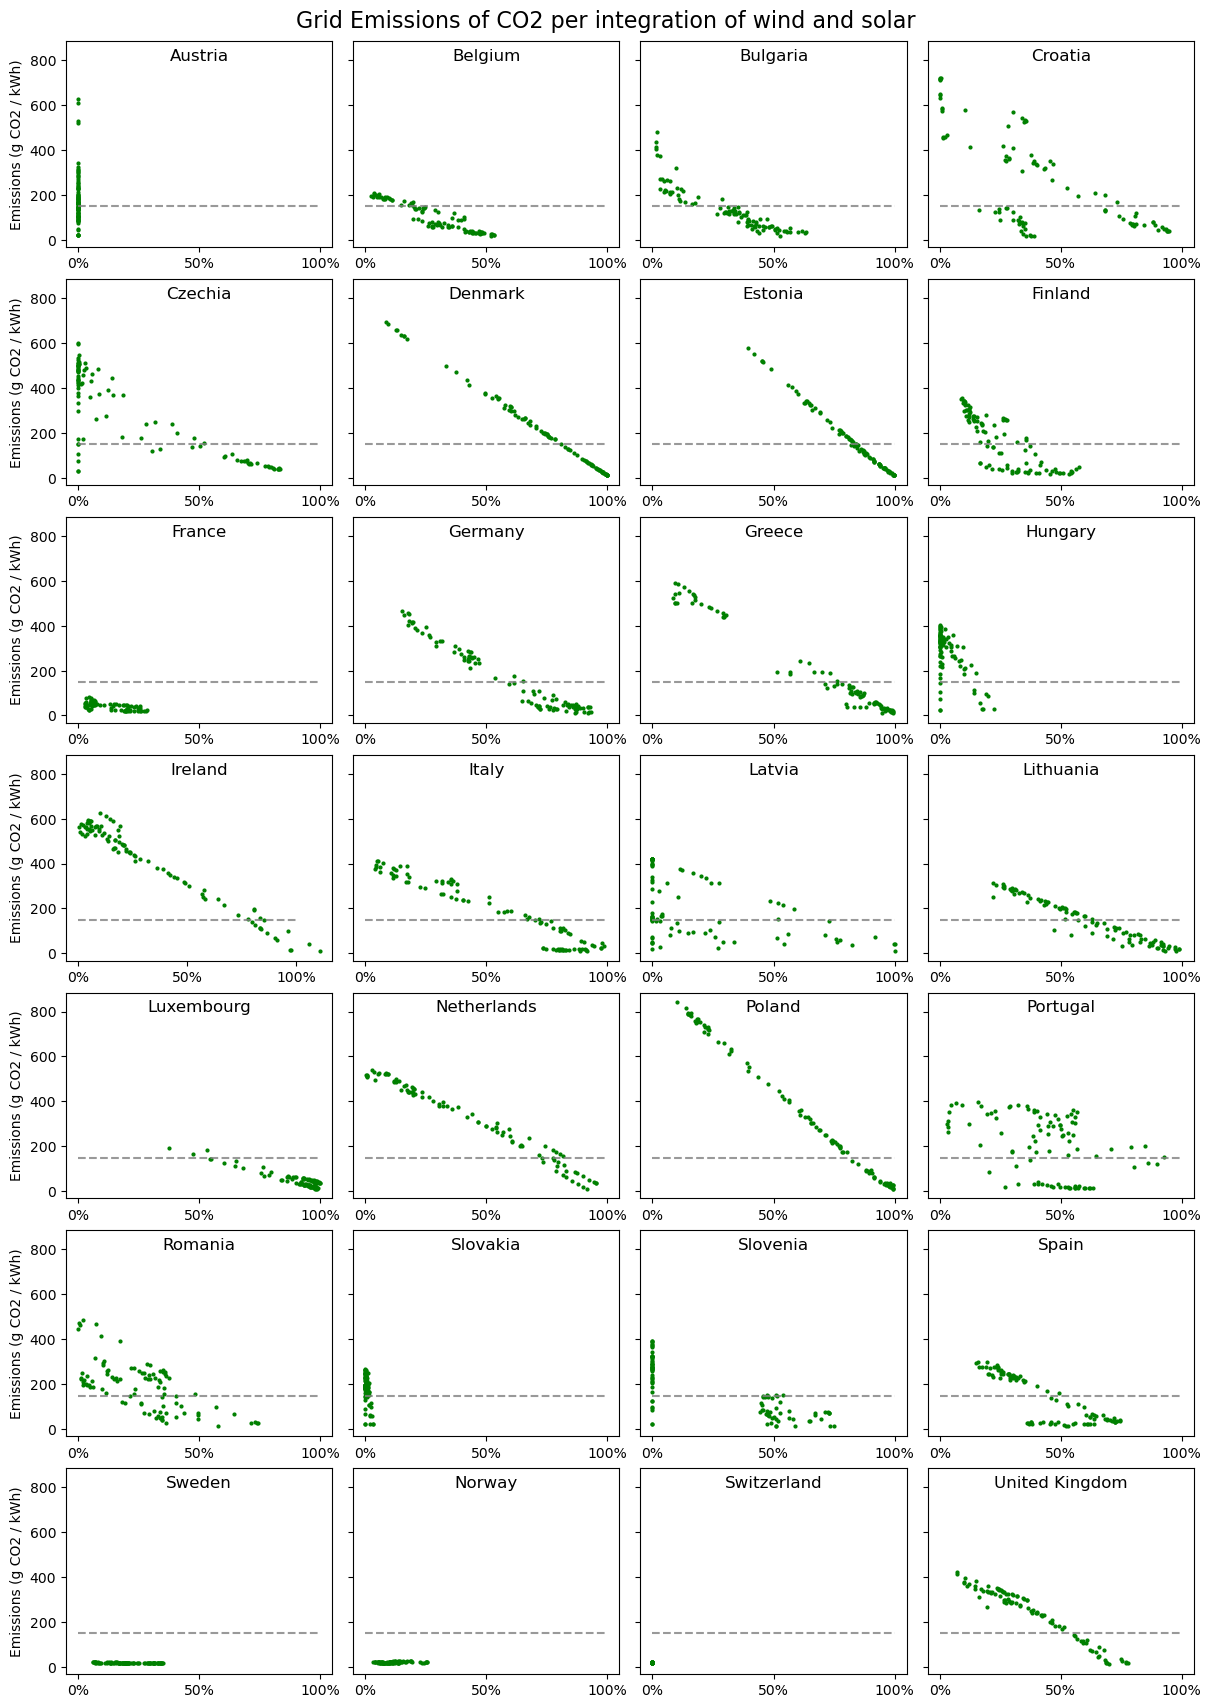

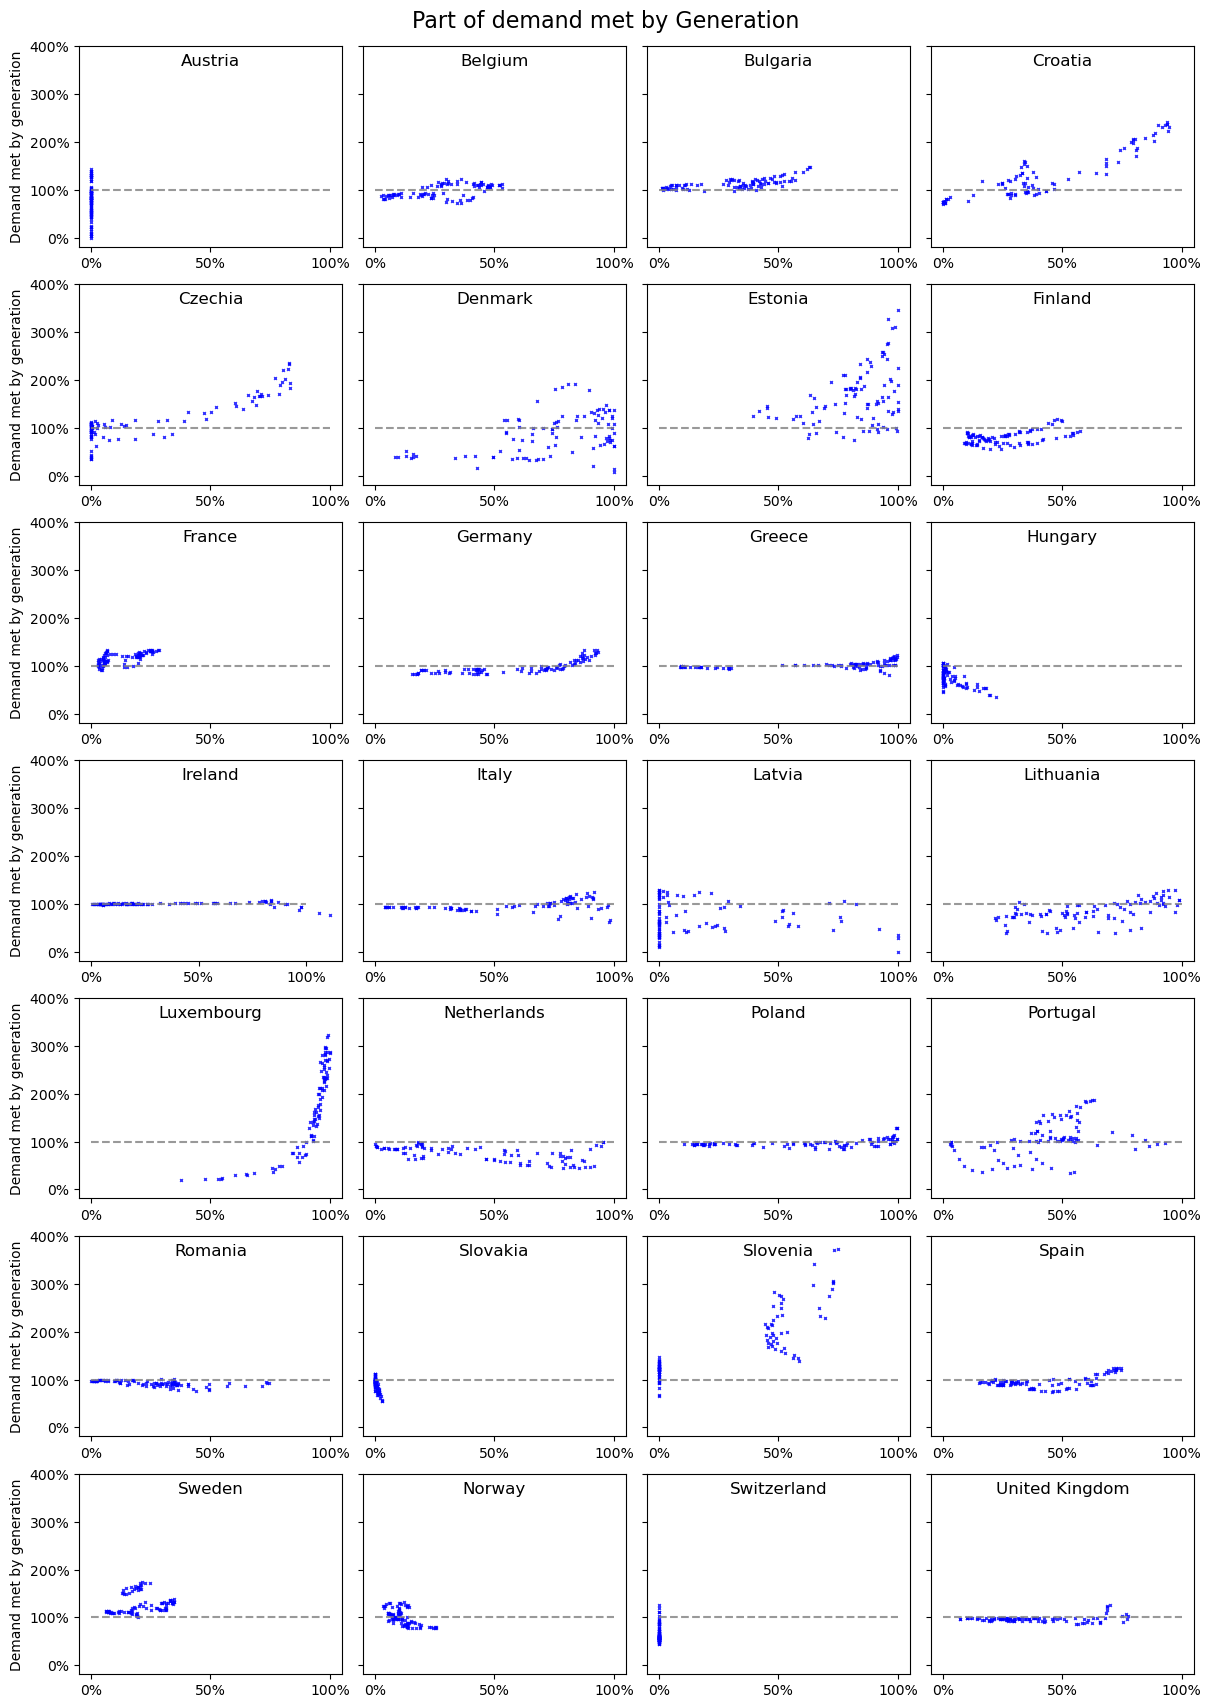

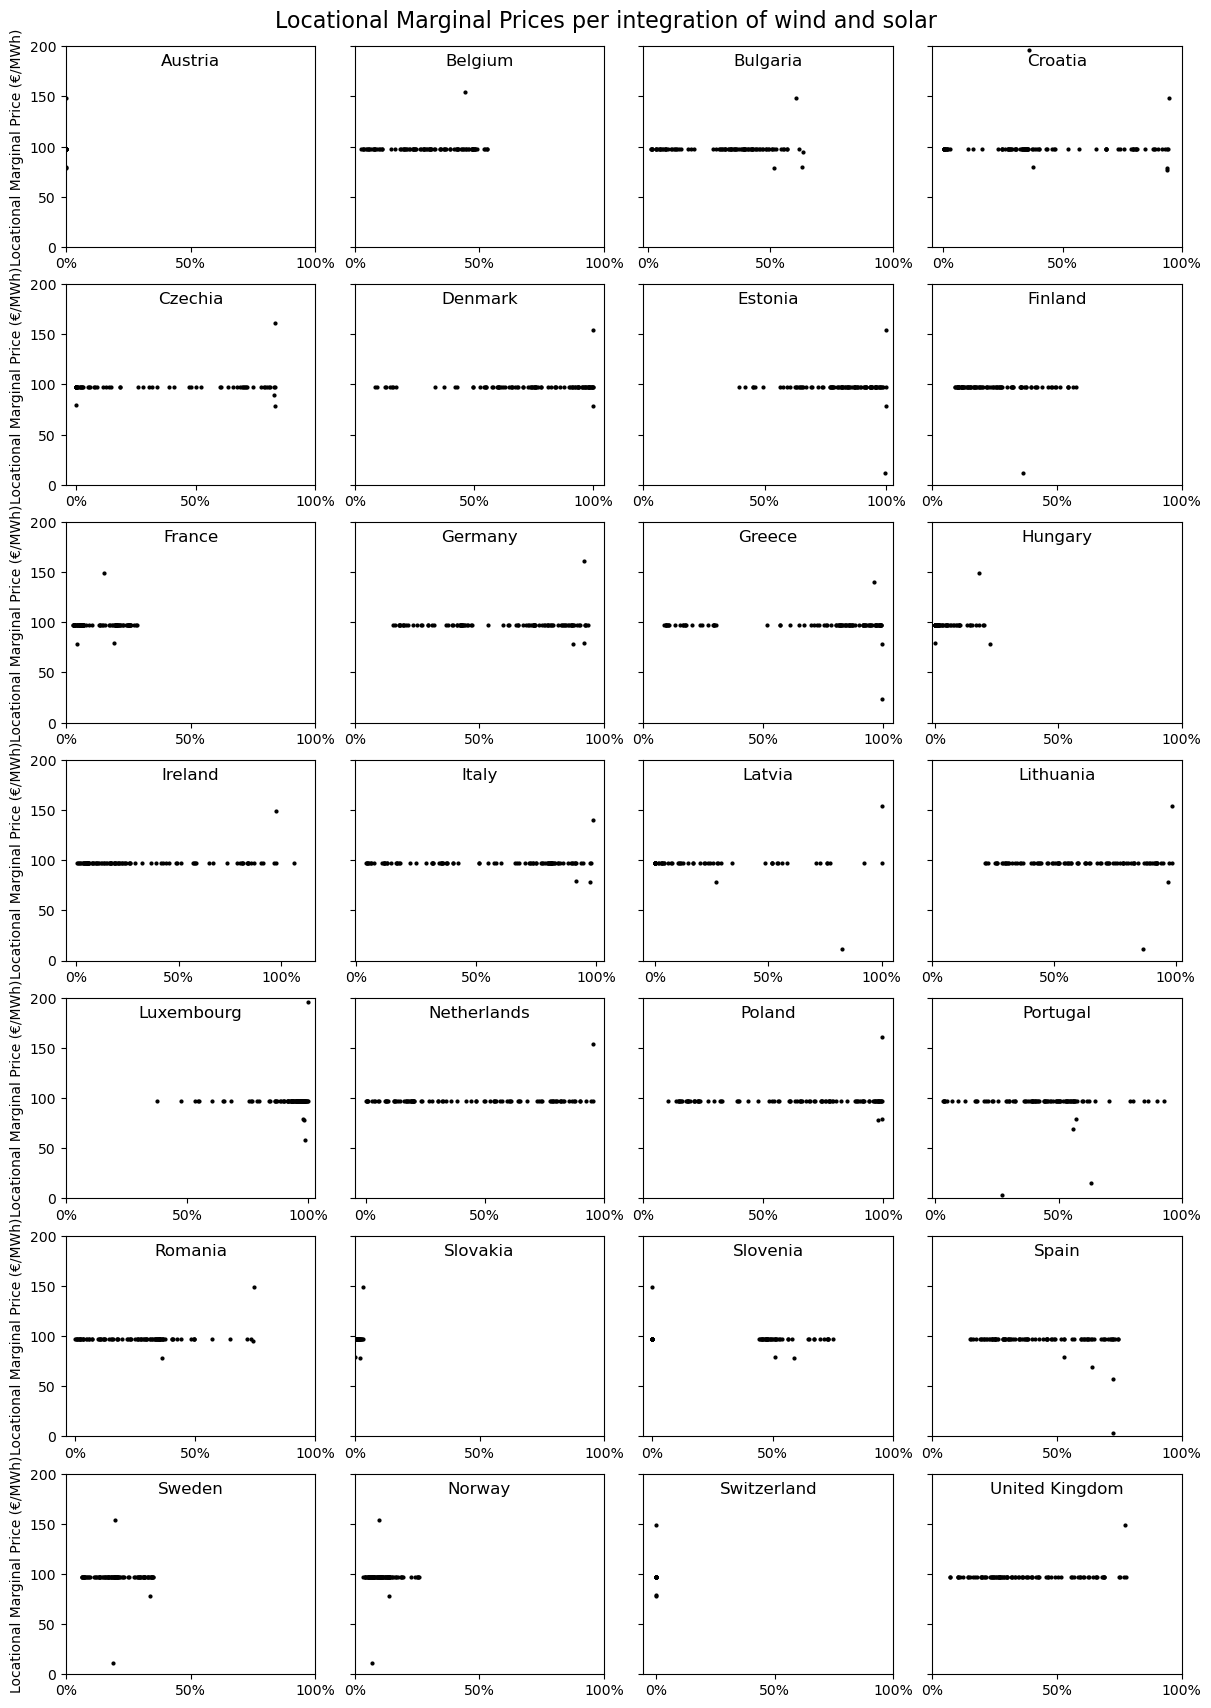

In [269]:
import matplotlib.ticker as mtick

h_size = 12

fig, ax = plt.subplots(7, 4, sharey=True, figsize=(h_size, h_size*1.414), constrained_layout=True)
fig2, ax2 = plt.subplots(7, 4, sharey=True, figsize=(h_size, h_size*1.414), constrained_layout=True)
fig3, ax3 = plt.subplots(7, 4, sharey=True, figsize=(h_size, h_size*1.414), constrained_layout=True)

fig.suptitle('Grid Emissions of CO2 per integration of wind and solar', fontsize=16)
fig2.suptitle('Part of demand met by Generation', fontsize=16)
fig3.suptitle('Locational Marginal Prices per integration of wind and solar', fontsize=16)

hours = [i for i in range(96)]

reverse_countries = {number: country for country, number in countries.items()}

for i in range(7):
    for j in range(4):
        country = reverse_countries[j+4*i]
        #print(country)
        total_generation     = data_output[country].iloc[:, 5:-1].sum(axis=1)
        renewable_generation = data_output[country].iloc[:, 5:7].sum(axis=1)
        emissions            = data_output[country]["Gen. Emissions"]        
        energy_autonomy      = total_generation/data_output[country]['Demand']
        marginal_price       = np.abs(data_output[country]['Bus Prices'])
        
        ax[i, j].plot(renewable_generation/total_generation, emissions, 'o', color='green', ms=2)
        ax2[i, j].plot(renewable_generation/total_generation, energy_autonomy, 'x', color = 'blue', alpha=.8, ms=2)
        ax3[i, j].plot(renewable_generation/total_generation, marginal_price, 'o', color='black', ms=2)
        
        ax[i, j].set_title(country, y=1, pad=-14)
        ax2[i, j].set_title(country, y=1, pad=-14)
        ax3[i, j].set_title(country, y=1, pad=-14)
        
        ax[i, j].hlines(y=150, xmin=0, xmax=1, ls='--', color='grey', alpha=0.8)
        ax2[i, j].hlines(y=1, xmin=0, xmax=1, ls='--', color='grey', alpha=0.8)
        ax3[i, j].set_ylim(0, 200)
        
        if j==0:
            ax[i, j].set_ylabel('Emissions (g CO2 / kWh)')
            ax2[i, j].set_ylabel('Demand met by generation')
            ax3[i, j].set_ylabel('Locational Marginal Price (€/MWh)')
                
        ax[i, j].set_xticks([0, 0.5, 1], ['0%', '50%', '100%'])
        ax2[i, j].set_xticks([0, 0.5, 1], ['0%', '50%', '100%'])
        ax3[i, j].set_xticks([0, 0.5, 1], ['0%', '50%', '100%'])
        
        ax2[i, j].set_yticks([0, 1, 2, 3, 4], labels=['0%', '100%', '200%', '300%', '400%'])

fig.savefig("Scenario 3 - Emissions per RE generation", bbox_inches='tight')
fig2.savefig("Scenario 3 - Autonomy per RE generation", bbox_inches='tight')
fig3.savefig("Scenario 3 - Locational Marginal Price per RE generation")
plt.show()

In [305]:
rows = ['System Costs', 'Solar Multiplier', 'Wind Multiplier', 'Electricity Imported', 'Electricity Exported', 'Solar Generation', 'Wind Generation', 'Coal Generation', 'Gas Generation', 'Biomass Generation', 'Nuclear Generation', 'Hydro Generation']
table_country = pd.DataFrame(index = rows)
#display(table_country)

for country in countries.keys():
    solar_gen_tot   = data_output[country]['Solar Generation'].sum()
    wind_gen_tot    = data_output[country]['Wind Generation'].sum()
    coal_gen_tot    = data_output[country]['Coal Generation'].sum()
    gas_gen_tot     = data_output[country]['Gas Generation'].sum()
    biomass_gen_tot = data_output[country]['Biomass Generation'].sum()
    hydro_gen_tot   = data_output[country]['Hydro Generation'].sum()
    nuclear_gen_tot = data_output[country]['Nuclear Generation'].sum()
    total_load      = data_output[country]['Demand'].sum()
    
    solar_costs   = LCOE_original['Solar']*solar_gen_tot
    wind_costs    = LCOE_original['Wind']*wind_gen_tot
    coal_costs    = LCOE_original['Coal']*coal_gen_tot
    gas_costs     = LCOE_original['Gas']*gas_gen_tot
    biomass_costs = LCOE_original['Biomass']*biomass_gen_tot
    hydro_costs   = LCOE_original['Hydro']*hydro_gen_tot
    nuclear_costs = LCOE_original['Nuclear']*nuclear_gen_tot
    total_costs   = solar_costs + wind_costs + coal_costs + gas_costs + biomass_costs + hydro_costs + nuclear_costs
    
    total_gen     = solar_gen_tot + wind_gen_tot + coal_gen_tot + gas_gen_tot + biomass_gen_tot + hydro_gen_tot + nuclear_gen_tot
    solarAmount   = solar_gen_tot   / total_gen
    windAmount    = wind_gen_tot    / total_gen
    coalAmount    = coal_gen_tot    / total_gen
    gasAmount     = gas_gen_tot     / total_gen
    biomassAmount = biomass_gen_tot / total_gen
    nuclearAmount = nuclear_gen_tot / total_gen
    hydroAmount   = hydro_gen_tot   / total_gen
    
    solarCapacity = data_output[country]['Solar Capacity'].iloc[0]
    windCapacity  = data_output[country]['Wind Capacity'].iloc[0]
    
    imports = pd.DataFrame(data_output[country]['Demand']-data_output[country].iloc[:,5:-1].sum(axis=1))
    # Calculate the percent of the load that had to be imported. Does not take exports into account.
    net_imports = imports.loc[imports[0] > 0]
    elec_import = float(net_imports.sum().iloc[0]) / total_load
    # Calculate the percent of the generation that was exported. Does not take import into account.
    net_exports = - imports.loc[imports[0] < 0]
    elec_export = float(net_exports.sum().iloc[0]) / total_gen
        
    if gendata[country]['Solar'] == 0:
        if solarCapacity == 0:
            solarMultiplier = 0
        else:
            solarMultipier = np.inf
    else:
        solarMultiplier = solarCapacity / gendata[country]['Solar']
        
    if gendata[country]['Wind'] == 0:
            if windCapacity == 0:
                windMultiplier = 0
            else:
                windMultipier = np.inf
    else:
        windMultiplier = windCapacity / gendata[country]['Wind'] 
    
    table_country[country] = [total_costs/1e6, solarMultiplier, windMultiplier, elec_import, elec_export, solarAmount, windAmount, coalAmount, gasAmount, biomassAmount, nuclearAmount, hydroAmount]

print(type(table_country['Austria'].iloc[0]))

format_dict = {
    'System Costs' : '{:.1f}M€',
    'Solar Multiplier': '{:.1f}',
    'Wind Multiplier': '{:.1f}',
    # For the other rows, convert to percentage with two decimal places
    'Electricity Imported': '{:.1%}',
    'Electricity Exported': '{:.1%}',
    'Solar Generation': '{:.1%}',
    'Wind Generation': '{:.1%}',
    'Coal Generation': '{:.1%}',
    'Gas Generation': '{:.1%}',
    'Biomass Generation': '{:.1%}',
    'Nuclear Generation': '{:.1%}',
    'Hydro Generation': '{:.1%}'
}

styled_df = table_country.T.style.format(format_dict, na_rep="-")
display(styled_df)

import dataframe_image as dfi
dfi.export(styled_df, 'Scenario 3 - Generation Table.png')

<class 'numpy.float64'>


,System Costs,Solar Multiplier,Wind Multiplier,Electricity Imported,Electricity Exported,Solar Generation,Wind Generation,Coal Generation,Gas Generation,Biomass Generation,Nuclear Generation,Hydro Generation
Austria,38.9M€,0.0,0.0,27.0%,6.1%,0.0%,0.0%,5.7%,21.8%,0.0%,0.0%,72.6%
Belgium,64.8M€,1.3,2.2,7.3%,5.3%,7.6%,22.4%,1.1%,15.5%,0.0%,53.5%,-0.0%
Bulgaria,32.9M€,4.1,4.8,0.1%,11.8%,14.6%,18.3%,8.7%,5.4%,0.0%,44.5%,8.4%
Croatia,20.6M€,115.2,1.6,5.1%,29.0%,39.5%,14.4%,12.8%,8.4%,0.0%,0.0%,24.9%
Czechia,68.3M€,9.4,0.0,7.3%,22.1%,37.4%,0.0%,20.2%,4.9%,0.0%,35.1%,2.4%
Denmark,20.8M€,0.0,1.7,24.9%,14.0%,0.0%,79.7%,11.5%,8.7%,0.0%,0.0%,0.0%
Estonia,9.2M€,0.0,14.9,1.3%,39.2%,0.0%,83.6%,13.3%,2.9%,0.0%,0.0%,0.1%
Finland,48.2M€,0.0,3.1,21.6%,0.7%,0.0%,26.5%,12.1%,7.2%,0.0%,37.7%,16.5%
France,389.5M€,0.0,1.9,0.4%,14.3%,0.0%,13.5%,1.3%,1.5%,0.0%,72.0%,11.7%
Germany,382.3M€,2.2,2.0,6.6%,5.0%,26.0%,37.0%,9.1%,9.5%,0.0%,15.4%,3.0%
